# Extreme precipitation: Changes under climate scenarios worfklow [Risk assessment]
Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/HEAVY_RAINFALL/main?labpath=EXTREME_PRECIPITATION_Risk_Assessment.ipynb) to launch this notebook on MyBinder.</br>
Click [![Heavy Rainfall](https://img.shields.io/badge/HEAVY_RAINFALL-repository-blue)](https://github.com/CLIMAAX/HEAVY_RAINFALL/tree/main) to go to this workflow's GitHub repository.

## Risk Assessment Methodology
The risk assessment methodology in this notebook follows the guidelines within the CLIMAAX project. <br>
To effectively assess the risk associated with extreme precipitation events and understand how the current local critical impact-based rainfall thresholds will vary under climate change scenarios, we'll need to consider two key factors:
* Rainfall intensity (Magnitude): <br>
This refers to the amount of rainfall that occurs within a specific timeframe, typically measured in millimetres per hour (e.g., mm/24h). Understanding the magnitude of a rainfall event is key for assessing its potential impact on the community, infrastructure, and environment.

* How often we can expect it (Frequency): <br>
Return periods indicate how often a rainfall event of a certain magnitude is expected to occur, on average. For instance, a 10-year return period means we can expect a rainfall event of that magnitude to occur approximately once every 10 years. Analysing return periods can help understand the frequency of extreme precipitation events and assess their likelihood of occurrence over time.


### Things to keep in mind before starting
* Identify critical impact-based rainfall thresholds in terms of **M**agnitude (mm), **D**uration (hours) and **F**requency (years)
 <br>
It is important to understand the “limits” or thresholds for rainfall intensity that could lead to significant impacts in your area or location of interest. These thresholds help us understand when rainfall becomes a risk to people, buildings, transportation, and other sectors. If you don’t have them, please refer to “Extreme precipitation: Local data requirements and interpretation for climate risk assessment.” This section will guide you in developing these thresholds based on local data to utilise the following risk assessment. 
* The risk assessment can be done for two spatial scales:
    * A specific-site or location
    * Entire regional assessment
 

The following workflow will guide you through the steps to carry out both types of assessment


### Hazard
In this workflow, we are exploring extreme precipitation and its potential change under different climate scenarios. To this end, we provide two options for accessing the expected precipitation data.
1. **If you’ve already done some preliminary work (Path B):**<br>
If you've executed the code in the [Hazard Assessment](EXTREME_PRECIPITATION_Hazard_Assessment.ipynb) Notebook, using the EURO-CORDEX dataset with workflow-defined settings of GCM, RCM, RCP, and time frames for your area (see first steps of the hazard assessment workflow), you're good to go! You can stick with the datasets you've already computed.

2. **Ready-to-Go datasets (Path A):**<br>
If you do not want to generate new rainfall datasets, you can use one of the pre-calculated European datasets provided by this workflow. These datasets have been calculated using the same method as in the Hazard Assessment i.e., using as input EURO-CORDEX climate projections for precipitation flux at a 12km spatial resolution and applying extreme value analysis. <br>
The combinations available are:
    * Global and Regional Climate Model chains (GCM/RCM): _ichec-ec-earth/RACMO22E; mohc-hadgem2-es/MOHC-HADREM_
    * Representative Concentration Pathway (RCP): rcp85
    * Historical time-frames: 1951-1980, 1971-2000, 1976-2005
    * Future time-frames: 2011-2040, 2041-2070, 2071-2100 (2070-2099 for _mohc-hadgem2-es_)
    * Durations: 3h, 6h, 12h, 24h

Please refer to the Hazard Assessment notebook to read about this dataset and its limitations.

### Exposure and vulnerability
Critical thresholds include exposure and vulnerability. Please refer to the [“Extreme Precipitation: Local data requirements and interpretation for climate risk assessment”](Extreme_precipitation_criticalthresholds.md) for more information. 

## Prepare your workspace
:::{admonition} Find out about the Python libraries we will use in this notebook.
:class: hint dropdown

* [xarray](https://docs.xarray.dev/en/stable/) - Introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays for a more intuitive experience.
* [rioxarray](https://corteva.github.io/rioxarray/stable/) - An extension of the xarray library that simplifies working with geospatial raster data.
* [osmnx](https://osmnx.readthedocs.io/en/stable/) - A Python package to easily download, model, analyze, and visualize street networks and other geospatial features from OpenStreetMap.
* [matplotlib](https://matplotlib.org/stable/) -  A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
* [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - A package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
* [contextily](https://contextily.readthedocs.io/en/latest/) - To retrieve matplotlib compatible tile maps from the internet.
* [pyproj](https://pyproj4.github.io/pyproj/stable/index.html) - A Python interface to PROJ (cartographic projections and coordinate transformations library).
* [geopandas](https://geopandas.org/en/stable/) - extends the datatypes used by pandas to allow spatial operations on geometric types.

### Load libraries

In [1]:
# Libraries to download data and manage files
import os
import glob
import osmnx
import pooch

# Libraries for numerical computations, array manipulation and statistics.
import xarray as xr
import pandas as pd
import numpy as np

# Libraries to handle geospatial data
import rioxarray as rio
import geopandas as gpd
from shapely import box
import pyproj
import rasterio

# Libraries to plot maps, charts and tables
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import contextily as ctx

# Choosing the matplotlib backend
%matplotlib inline

## Step 1: Select your analysis area

Before downloading the data, let’s define the coordinates of our area of interest. Based on these coordinates, we can clip the datasets for further processing. If you're already using a dataset generated from option one of the hazard section, feel free to skip this step.

However, if you are working with the European scale precipitation datasets (option 2), please define your area of interest using the [Bounding Box Tool](https://boundingbox.klokantech.com). Make sure to select CSV (coordinates) in the lower left corner and copy the values in the brackets below.

Use the code below to define your area of interest. The region of Catalonia is defined as an example of both approaches

In [2]:
bbox = [0, 40.2, 3.3, 43.5]; areaname = 'Catalonia'

### Setting your directory structure
The next cell will create the *extreme_precipitation_risk* folder in the directory where the notebook is saved. You can change the absolute path defined in the variable ```workflow_dir``` to create it elsewhere.

In [3]:
# Define the path for the extreme_precipitation_risk folder.
workflow_dir = 'extreme_precipitation_risk'
# workflow_dir = 'flashflood_workflow'
# Create the directory checking if it already exists.
os.makedirs(workflow_dir, exist_ok=True)

Now, we will create a subfolder for general data as well as specific subfolders to save data for our area of interest, plots generated by the code and new datasets computed within the workflow.

In [4]:
# Define directories for general data.
general_data_dir = os.path.join(workflow_dir, 'general_data')
# Define specific directories for the selected area
data_dir = os.path.join(workflow_dir, f'data_{areaname}')
results_dir = os.path.join(workflow_dir, f'results_{areaname}')
plots_dir = os.path.join(workflow_dir, f'plots_{areaname}')

# Create the directories checking if they already exist.
os.makedirs(general_data_dir, exist_ok = True)
os.makedirs(data_dir, exist_ok = True)
os.makedirs(results_dir, exist_ok = True)
os.makedirs(plots_dir, exist_ok = True)

We also need to define the path of the *extreme_precipitation_hazard* folder in order to access the files previously downloaded and created in the _Hazard Assessment_ notebook.

In [5]:
# Define the hazard directory
hazard_dir = 'extreme_precipitation_hazard'
# Define the subfolder's paths
hazard_general_data_dir = os.path.join(hazard_dir, 'general_data')
hazard_data_dir = os.path.join(hazard_dir, f'data_{areaname}')
hazard_results_dir = os.path.join(hazard_dir, f'results_{areaname}')

### Prepare access to the ready-to-go pre-calculated European datasets

Load the file registry for the `precipitation_idf_gcm_eur` dataset in the CLIMAAX cloud storage with pooch.

If any files requested below were downloaded before, pooch will inspect the local file contents and skip the download if the contents match expectations.


In [6]:
precip_data_pooch = pooch.create(
    path=general_data_dir,
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/precipitation_idf_gcm_eur/"
)
precip_data_pooch.load_registry("files_registry.txt")

## Step 2: Calculate or identify your critical impact-based rainfall thresholds in terms of Magnitude, Duration and Frequency

It’s important to define the area we'll be analysing to select (or derive) the critical impact-based rainfall thresholds. This could be a specific location, city, region, watershed, or any other relevant geographic area. Understanding the extent of our analysis helps us tailor our thresholds to the area’s specific characteristics and risks. 

If you are unsure how to set up these thresholds, do not worry! Please refer to the "Extreme precipitation: Local data requirements and interpretation for climate risk assessment" section. 


## Step 3: Load the hazard data
As explained above, the precipitation datasets that will be used in this workflow as input can come from following the two paths mentioned in the section [You have your critical thresholds, now what?](Extreme_precipitation_criticalthresholds.md#you-have-your-critical-thresholds-now-what).

- If you have followed path A, you will use one of the ready-to-go pre-calculated European datasets. See more information on available combinations [here](Extreme_precipitation_criticalthresholds.md#path-a-lets-jump-straight-into-a-climate-risk-assessment).
- If you have followed path B, you have generated your current and future rainfall datasets by executing the steps of the [Extreme precipitation: Changes under climate scenarios workflow [Hazard assessment]](EXTREME_PRECIPITATION_Hazard_Assessment.ipynb), using the climate scenario or Global/Regional combination that best fits your regional context.

Both datasets are almost exactly structured and only some differences in coordinates and variables are present. To select which dataset you will use based on your path, define the variable ```DATASET_HAZARD_ASSESSMENT``` as True or False.

1. If you're using one of the ready-to-go pre-calculated European datasets (**Path A**), define ```DATASET_HAZARD_ASSESSMENT``` to False.
1. If you're using the datasets generated from the hazard assessment (**Path B**), define ```DATASET_HAZARD_ASSESSMENT``` to True.

:::{note}
**If you're using the ready-to-go pre-calculated European datasets, make sure to define the ```DATASET_HAZARD_ASSESSMENT``` as False** and check for the available combinations of the Global Circulation Model (GCM) and Representative Concentration Pathways (RCP) provided in the hazard section. Once you've downloaded these from the pre-calculated datasets, we'll slice them to our area of interest defined in lat/lon coordinates in the bounding box and save the new files in the data directory of the Risk Assessment notebook for easy access later on
:::

Explore the code below to understand how to load the hazard data. Again the region of Catalonia is used to exemplify the code with the following specifications:


<table border="1">
  <tr>
    <th style="text-align: left;">Attribute</th>
    <th style="text-align: left;">Non-bias corrected datasets</th>
    <th style="text-align: left;">Bias-corrected datasets</th>
  </tr>
  <tr>
    <td style="text-align: left;">Global and Regional Climate Model Chains<br></td>
    <td style="text-align: left;">
        ichec-ec-earth/RACMO22E <br>
        mohc-hadgem2-es/RACMO22E<br>
        mpi-m-mpi-esm-lr/SMHI-RCA4<br>
    </td>
    <td style="text-align: left;">
        ichec-ec-earth/RACMO22E <br>
        mohc-hadgem2-es/RACMO22E<br>
        mpi-m-mpi-esm-lr/SMHI-RCA4<br>
    </td>
  </tr>
  <tr>
    <td style="text-align: left;">Representative Concentration Pathway (RCP)<br></td>
    <td style="text-align: left;">rcp 4.5<br>rcp 8.5</td>
    <td style="text-align: left;">rcp 4.5<br>rcp 8.5</td>
  </tr>
  <tr>
    <td style="text-align: left;">Historical Time-frames<br></td>
    <td style="text-align: left;">1951-1980<br>1971-2000<br>1976-2005<br></td>
    <td style="text-align: left;">1971-2000<br>1976-2005<br></td>
  </tr>
  <tr>
    <td style="text-align: left;">Future Time-frames<br></td>
    <td style="text-align: left;">2011-2040<br>2041-2070<br>2071-2100 <br></td>
    <td style="text-align: left;">2011-2040<br>2041-2070<br>2071-2100 <br></td>
  </tr>
  <tr>
    <td style="text-align: left;">Durations<br></td>
    <td style="text-align: left;">3h<br>24h<br></td>
    <td style="text-align: left;">24h<br></td>
  </tr>
</table>

Feel free to modify the code based on your research needs.



In [7]:
# Define global variable to define the dataset to use (False to use ready-to-go pre-calculated datasets  Path A)
DATASET_HAZARD_ASSESSMENT = True

# Define global climate model for the selected CGM/RCM chain selected (matching the ones defined in Path B or within the ready-to-go pre-calculated datasets  Path A)
GCM = 'ichec-ec-earth'
RCP = 'rcp85'

# Select which time-frames and durations within the available you want to study (Check for options above) or choose the ones computed in the Hazard Assessment.
TIME_FRAMES = {
    'historical' :'1976-2005',
    RCP : '2041-2070' 
}

# Define durations to read/download
DURATIONS = [3, 24]

# Dictionary of hazard dataset path's (filled automatically with the information of above)
HAZARD_PATHS = {}

In [8]:
# (if needed) Download pre-calculated European datasets
if not DATASET_HAZARD_ASSESSMENT:
    # Download all files for the selected GCM
    for path in precip_data_pooch.registry:
        if path.startswith(GCM):
            precip_data_pooch.fetch(path)

# Fill the HAZARD_PATHS dictionary and (if needed) slice the european datasets to the area of interest 
for dur in DURATIONS:
    HAZARD_PATHS[dur] = {}
    for run, years in TIME_FRAMES.items():
        if DATASET_HAZARD_ASSESSMENT:
            HAZARD_PATHS[dur][run] = os.path.join(hazard_results_dir, f'idf_{dur}h_{GCM}_{run}_{years}.nc')

        else:
            path = glob.glob(os.path.join(general_data_dir, GCM, run, f'idf_{dur}h*_{years}.nc'))[0]
            path_out = os.path.join(data_dir, os.path.basename(path))
            if not os.path.exists(path_out):
                with xr.open_dataset(path, decode_cf = True) as ds:
                    # Cut bounding box area
                    # Reproject usual coordinates (in WGS84) to EURO-CORDEX's CRS.
                    CRS = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
                    transformer = pyproj.Transformer.from_crs('epsg:4326',CRS)
                    West, South, East, North = bbox
                    rlon_min, rlat_min, rlon_max, rlat_max = transformer.transform_bounds(South, West, North, East)
                    # slice European dataset to area of region using boundig box.
                    ds = ds.sel(rlat = slice(rlat_min, rlat_max), rlon = slice(rlon_min, rlon_max))
                    # Save in data_dir directory for further use
                    ds.to_netcdf(path_out)
            HAZARD_PATHS[dur][run] = path_out

## Step 4: Define a function to compute magnitude and frequency shifts

The code in this section will help us translate and link your real-world data (either location or regional scale) to the climate dataset projections we're using in this workflow (non-biased corrected EURO-CORDEX). This step is necessary for improving the robustness of our analysis with the climate projections.

Given a local impact critical treshold for extreme precipitation defined in terms of precipitation, duration and return period, we are going to define a function that translates the changes EURO-CORDEX simulates into:
* Future return periods for current critical intensities (precitation/duration).
* Future expected precipitation when frequency (return period) is held fixed.

To compute this shifts, we will need the hazard data from both the baseline and the future horizon that wants to be studied, as well as the local critical threshold of a specific point or region. The latter is thought to be provided by the user, as it is defined with local and historic information of each site.

In [9]:
def magnitude_frequency_shift(th_int, th_dur, th_freq, ds_baseline, ds_horizon, is_bias_corrected):
    """ Returns the new magnitudes and frequencies of given threshold under climate change.

        th_int: intensity (critical threshold)
        th_dur: duration (critical threshold)
        th_freq: frequency (critical threshold)
        ds_baseline : dataarray of expected precipitation of the baseline period. DataArray index is expected to be 'return_period'.
        ds_horizon : same specifications as ds_baseline for future horizon (e.g. 2070)
        is_bias_corrected: if the Cordex Datasets are bias corrected (True) or non-bias corrected (False)
    """
    # Access data (return_periods and values for baseline and future)
    ret_per_bs = ds_baseline.return_period.values
    ret_per_proj = ds_horizon.return_period.values
    prec_bs = ds_baseline.values
    prec_proj = ds_horizon.values

    if not is_bias_corrected:
        # Translation of threshold into baseline eurocordex (interpolation of precipitation vs. log(return periods)).
        prec_base_aux = np.interp(np.log(th_freq), np.log(ret_per_bs), prec_bs)
    else:
        prec_base_aux = prec_bs

    ### Change in frequency
    # Get new frequency by interpolation
    shift_ret_per = np.interp(prec_base_aux, prec_proj, np.log(ret_per_proj))
    shift_ret_per = np.ceil(np.exp(shift_ret_per))

    ### Change in magnitude using proxy of baseline.
    # Get new precipitation by interpolation
    prec_proj_aux = np.interp(np.log(th_freq), np.log(ret_per_proj), prec_proj)
    factor_prec = prec_proj_aux/prec_base_aux
    shift_prec = th_int * factor_prec

    # Rounding values to 2 decimals.
    shift_prec = round(shift_prec, 2)
    factor_prec = round(factor_prec, 2)

    return shift_ret_per, shift_prec, factor_prec

## Step 5: Specify your critical impact-based rainfall thresholds
Now that you have defined your analysis area, we can explore how your critical impact-based rainfall thresholds will change based on climate projections. There are two possible alternatives based on the scale of the defined critical thresholds of step 2. These can be for:

* A specific location or point within your area of interest **(site-specific risk assessment)**
* The entire analysis area **(regional risk assessment)**: Recommended for broader coverage, such as analysing a large city or entire region. Please refer to the Risk assessment - local examples to explore more regional and city-scale cases.

### For a specific-site or location in your analysis area

In the below section, specify the local critical thresholds in the following terms:
* Magnitude (milimeters)
* Duration (3 hours, 24 hours)
* Frequency/return period (10, 25, 50 years)

Additionally, provide the latitude and longitude of the location of interest. 
 
To exemplify the code, we set up an **illustrative threshold for location A in 100/mm in 24 hours with a return period of 5 years.**


In [10]:
# Define the parameters of your threshold.
INTENSITY_TH = 100     # in mm
DURATION_TH = 24       # in hours
FREQUENCY_TH = 5       # in years

# Lat/lon coordinates for Blanes locality.
POINT = [41.674, 2.792]

In [11]:
# Transform POINT to Hazard dataset reference system
CRS = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326', CRS)
rpoint = transformer.transform(POINT[0], POINT[1])

# Read historical IDF for point
ds_hist = xr.open_dataset(HAZARD_PATHS[DURATION_TH]['historical'], decode_cf=True)
ds_hist = ds_hist.sel(rlat = rpoint[1], rlon = rpoint[0], duration=DURATION_TH, method = 'nearest', drop=True).idf

# Read future IDF for point
ds_proj = xr.open_dataset(HAZARD_PATHS[DURATION_TH][RCP], decode_cf=True)
ds_proj = ds_proj.sel(rlat = rpoint[1], rlon = rpoint[0], duration=DURATION_TH, method='nearest', drop=True).idf

# Apply function to poing
shift_point = magnitude_frequency_shift(INTENSITY_TH, DURATION_TH, FREQUENCY_TH, ds_hist, ds_proj, False); del ds_hist, ds_proj

### For an entire region
When analysing an entire region, you'll need to present your critical thresholds in a TIFF format, such as the one seen in the left map of in [example 1](https://handbook.climaax.eu/notebooks/workflows/HEAVY_RAINFALL/01_Extreme_precipitation/EXTREME_PRECIPITATION_Risk_Assessment_examples.html#id1). 

#### Keep in mind
- **Format**: Make sure your TIFF file show the critical threshold in terms of **M**agnitude, **D**uration, and **F**requency.
- **File Organization**: We recommend creating one TIFF file for each critical threshold. For example, you have a TIFF file showing the return periods for a 100 mm/24-hour rainfall event in Region A.

#### Need help?

Check out the "[Risk Assessment - Local Examples](EXTREME_PRECIPITATION_Risk_Assessment_examples.ipynb#for-the-entire-region-of-catalonia)" section to see how the TIFF files were created for the Catalonia region example. 

Please provide your critical thresholds in a TIFF format in the code below. The ```magnitude_frequency_shift``` function will be applied to each pixel and the results will be saved as GeoTIFF's in the new directory.

In [15]:
print('Downloading Catalonia thresholds...')
path_rp_th = precip_data_pooch.fetch("RP_CAT_threshold_100mm.tiff")

# Load and plot the return period for critical threshold.
print("Loading Catalonia thresholds...")
ds_rp_th = rio.open_rasterio(path_rp_th)

# Access projection and data values
proj_rp_th = ds_rp_th.rio.crs
transform_rp_rh = ds_rp_th.rio.transform()
nvar, ny, nx = ds_rp_th.shape
data = ds_rp_th.values

# Create new arrays for return period shift, precipitation shift and precipitation factor.
sh_rp = np.full((ny,nx), fill_value=ds_rp_th._FillValue, dtype='float32')
sh_prec = np.full((ny,nx), fill_value=ds_rp_th._FillValue, dtype='float32')
sh_prec_factor = np.full((ny, nx), fill_value=ds_rp_th._FillValue, dtype='float32')

# Transform lat/lon coordinates into Hazard Dataset CRS.
xy_th = np.asarray(np.where(data > 0))[[2,1],:]
trans_th_haz = pyproj.Transformer.from_crs(proj_rp_th, CRS)
lonlat_th = np.asarray(trans_th_haz.transform(ds_rp_th.x[xy_th[0]], ds_rp_th.y[xy_th[1]]))

# Read historical and future datasets
ds_hist = xr.open_dataset(HAZARD_PATHS[DURATION_TH]['historical'], decode_cf=True)
ds_future = xr.open_dataset(HAZARD_PATHS[DURATION_TH][RCP], decode_cf=True)

# Loop over each pixel to compute transformation
for i in range(len(xy_th[0])):
    th_rp_i = ds_rp_th.isel(x = xy_th[0, i], y = xy_th[1, i]).values[0]
    data_hist = ds_hist.idf.sel(rlon = lonlat_th[0,i], rlat = lonlat_th[1,i], method='nearest').sel(duration=DURATION_TH)
    data_future = ds_future.idf.sel(rlon = lonlat_th[0,i], rlat = lonlat_th[1,i], method='nearest').sel(duration=DURATION_TH)

    # Calling shift function
    shift = magnitude_frequency_shift(INTENSITY_TH, DURATION_TH, th_rp_i, data_hist, data_future, False)
    sh_rp[xy_th[1, i], xy_th[0, i]] = shift[0]
    sh_prec[xy_th[1, i], xy_th[0, i]] = shift[1]
    sh_prec_factor[xy_th[1, i], xy_th[0, i]] = shift[2]

Loading Catalonia thresholds...


In [16]:
def write_geotiff(filename, data):
    path_tiff = os.path.join(results_dir, filename)
    with rasterio.open(
        path_tiff,
        'w',
        driver='GTiff',
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype,
        crs=proj_rp_th.to_wkt(),
        nodata=ds_rp_th._FillValue,
        transform=transform_rp_rh,
        tiled=True,
        copy_src_overviews=True,
        compress='DEFLATE',
        predictor=3
    ) as dst:
        dst.write(data, 1)
        
# Save each variable as GeoTIFF in results directory.
filename_rp = f"RP_shift_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_rp, sh_rp)

filename_prec = f"PREC_shift_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_prec, sh_prec)

filename_factor = f"PREC_factor_threshold_100mm_{TIME_FRAMES['historical']}_{TIME_FRAMES[RCP]}.tiff"
write_geotiff(filename_factor, sh_prec_factor)


## Step 6: Let's explore our results!
In this last step, we will take a look at the results. The following code will provide information into how your critical thresholds can vary in terms of:

1. Change in Magnitude (%): This represents the relative percent change between your current magnitude (baseline) and a year within the climate projections (e.g., 2070) if your current frequency remains fixed. For example, what will be the percentual increase (or decrease) in rainfall intensity in 24 hours associated with the return period of 10 years in 2070?
2. Change in Return period (value): Here, you'll see the new frequency or return period value if you choose to fix the current magnitude. For example, what will be the new return period (or frequency) of 100 mm/24 hours in 2070?


### For a specific-site within the region
We can print the results using the code below:


In [17]:
print(f"For the period of {TIME_FRAMES[RCP]}, the critical impact-based rainfall threshold of {INTENSITY_TH} mm/{DURATION_TH} hours, associated with a {FREQUENCY_TH}-year return period:")
print(f"   * If we want to maintain the same frequency (return period), the magnitude will vary by {(shift[2]-1)*100:.2f} % from the current threshold")
print(f"   * If we want to maintain the same magnitude, the frequency (return period) will change from {FREQUENCY_TH} to {shift_point[0]} years.")

For the period of 2041-2070, the critical impact-based rainfall threshold of 100 mm/24 hours, associated with a 5-year return period:
   * If we want to maintain the same frequency (return period), the magnitude will vary by 19.00 % from the current threshold
   * If we want to maintain the same magnitude, the frequency (return period) will change from 5 to 3.0 years.


### For an entire region

We can organise our results to plot them for better understanding. Please keep in mind that the code in this section is most suitable for areas such as regions, cities or defined spatial sections. For specific locations like roads, vulnerable sites or hotspots, the visualisation might not provide sufficient insights due to the spatial resolution of the provided climate model’s pixels (12 km)

Use the code below to visualise your results. Feel free to modify the colour palettes based on your research needs.
:::{tip}
Modify the colors and delimitation bounds of the colormap to better visualise the results. 
:::

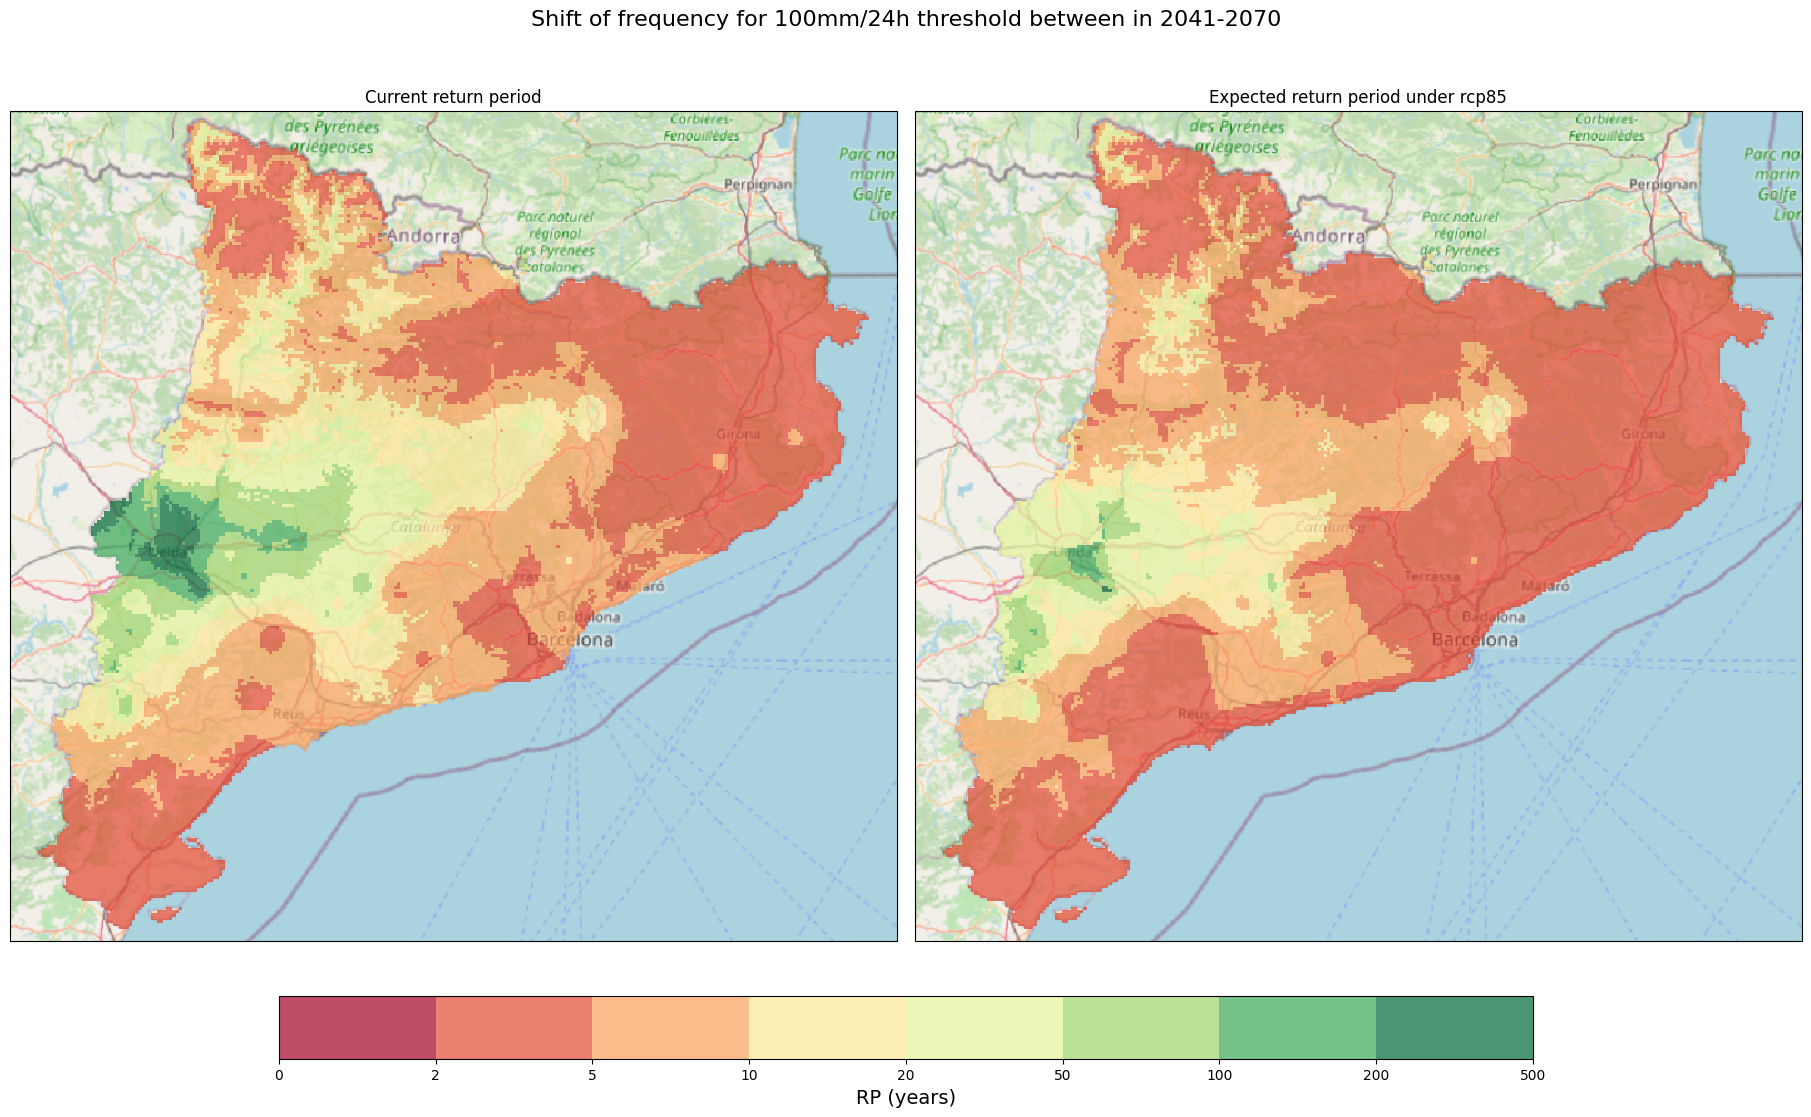

In [20]:
# Convert projection so matplotlib understands it.
proj_rp_map = ccrs.epsg(proj_rp_th.to_epsg())
# Path of rasters to plot.
r1 = path_rp_th
r2 = glob.glob(os.path.join(results_dir, 'RP_shift*.tiff'))[0]
# Define colorbar.
cmap_ret_per = plt.get_cmap("RdYlGn")
bounds_ret_per = [0, 2, 5, 10, 20, 50, 100, 200, 500]
norm_ret_per = mpl.colors.BoundaryNorm(bounds_ret_per, cmap_ret_per.N)
fig_rp, ax_rp = plt.subplots(1,2, figsize = (18,11), subplot_kw = {'projection': proj_rp_map}, layout = 'constrained')
for i, file in enumerate([r1, r2]):
    ds_i = rio.open_rasterio(file, masked =True)
    im = ds_i.plot(ax = ax_rp[i], add_colorbar=False, norm = norm_ret_per, cmap=cmap_ret_per, alpha = 0.7)
    ctx.add_basemap(ax=ax_rp[i], crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik,
               attribution = False)

ax_rp[0].set_title('Current return period')
ax_rp[1].set_title(f'Expected return period under {RCP}')
cb_rp = fig_rp.colorbar(im, ax = ax_rp[:], ticks=bounds_ret_per, location='bottom', shrink = 0.7)
cb_rp.set_label('RP (years)', fontsize = 14)
fig_rp.suptitle(f"Shift of frequency for 100mm/24h threshold between in {TIME_FRAMES[RCP]}",fontsize = 16)
plt.show()

fig_rp.savefig(os.path.join(plots_dir, f'RP_shift_threshold_{TIME_FRAMES[RCP]}.png'))

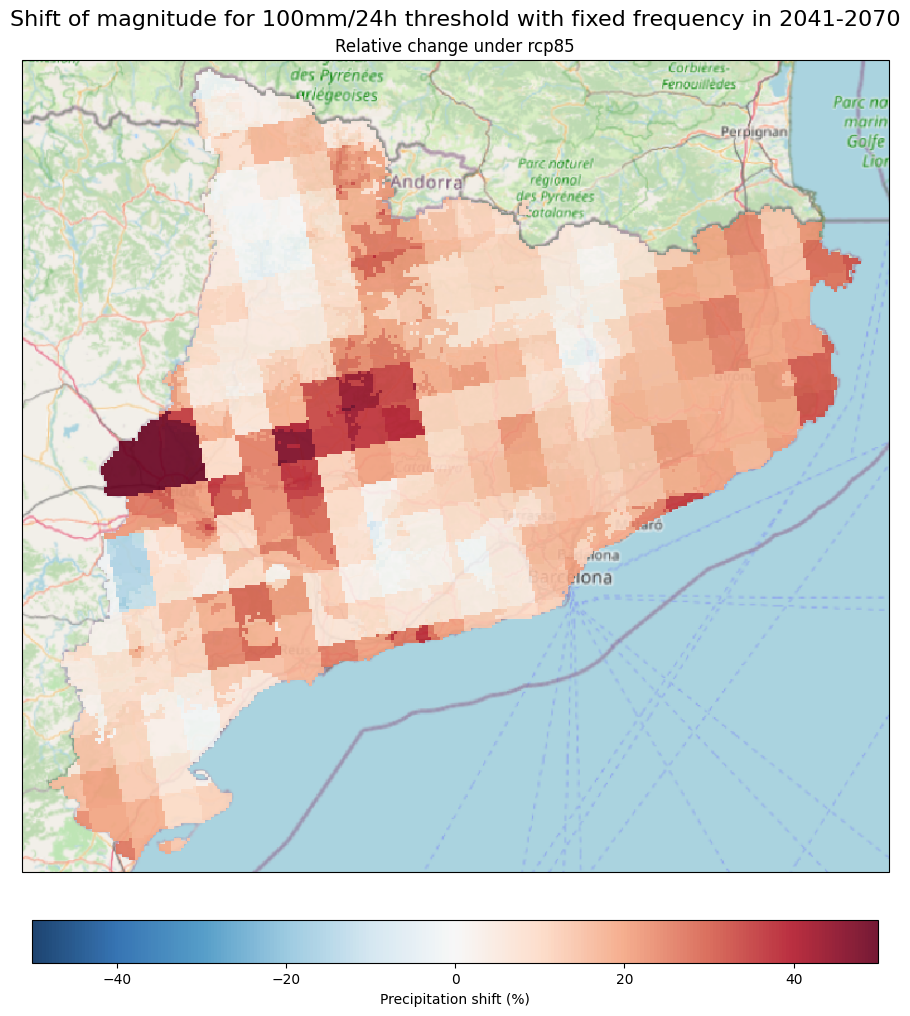

In [23]:
# Path of rasters to plot.
r4 = glob.glob(os.path.join(results_dir, 'PREC_factor*.tiff'))[0]

fig, ax = plt.subplots(figsize = (17,10), subplot_kw = {'projection': proj_rp_map}, layout = 'constrained')

ds_rel = rio.open_rasterio(r4, masked =True)
ds_rel = (ds_rel-1)*100
im_rel = ds_rel.plot(ax = ax, add_colorbar=False,cmap='RdBu_r', vmin=-50, vmax=50, alpha = 0.9)

cb_rel = fig.colorbar(im_rel, ax = ax, location ='bottom', shrink = 0.5 )
cb_rel.set_label('Precipitation shift (%)')
ctx.add_basemap(ax=ax, crs=proj_rp_map, source=ctx.providers.OpenStreetMap.Mapnik,
               attribution = False)

ax.set_title(f'Relative change under {RCP}')
fig.suptitle(f'Shift of magnitude for 100mm/24h threshold with fixed frequency in {TIME_FRAMES[RCP]}',fontsize = 16)
plt.show()
fig.savefig(os.path.join(plots_dir, f'PREC_shift_threshold_{TIME_FRAMES[RCP]}.png'))

## Things to consider
1. Climate model outcomes **should not be interpreted as forecasts but as projections** based on a specific emission scenario. Always provide the full result information (scenario, global and regional models, time slice, region, spatial resolution, duration).
<br>
<br>
2. The workflow uses three different time slices: **Near-term** (2011-2040), **Mid-term** (2041-2070), and **Future-term** (2071-2100) based on the typical periods used to characterise future climate change (20—or 30-year periods). Concurrently, the baseline period from simulations (1976-2005) serves as the reference against which differences or future changes are assessed. In this workflow, functions (refer to step 4) are defined to facilitate the translation and linkage of your real-world data, such as critical rainfall thresholds at local or regional scales, to climate dataset projections (both baseline and future). For practical examples of implementing these steps in European regions, please refer to the “Extreme precipitation: Examples on how to carry out a climate risk assessment” section.
<br>
<br>
3. As a starting point in EURO-CORDEX, **no chain of global to regional models is considered the most appropriate or “best”**. Therefore, the first recommendation suggested by Benestad et al., (2021) is to treat all model combinations as equal. Only after an in-depth evaluation of all regional model results, can there be an indication to sort out particular models for a region. See more in Maraun et al. (2015) and Kotlarski et al. (2017).
<br>
<br>
4. Climate models vary not only in their specific details but also in how they are configured. These variations **can cause different outcomes across models**, even when they use the same starting conditions or boundary inputs. Moreover, differences in results from regional models may arise from the methods used to simulate regions, such as whether they employ dynamical or statistical downscaling techniques. Consequently, utilising one chain of GCM/RCM only provides one potential effect. **An ensemble analysis is recommended if the risk assessment aims to address the inherent uncertainties in climate models for a specific region (see point 5)**. 
<br>
<br>
5. **An ensemble model simulation** can consist of **different chains of GCM/RCM but only one RCP scenario (multi-model-ensemble)** or **one model and different RCP scenarios (multi-scenario-ensemble)**. Analysing ensemble members’ mean and standard deviation is the simplest method to estimate uncertainty, but other methods exist. However, conducting this analysis can be time and resource-consuming due to the number of simulations needed, making it impractical or unfeasible in some cases. For more information, please refer to Christensen et al., (2020), Knutti et al., (2010), Déqué et al., (2007).
<br>
<br>
6. **To carry out an ensemble model simulation, you simply need to repeat (or loop through) steps 3, 5 and 6 in this workflow for the different RCP scenarios or GCM/RCM chains**. The workflow already provides pre-calculated datasets for two GCM/RGMA chains and RCPs. If additional simulations are required, please refer to the “**[Extreme precipitation: Changes under climate scenarios workflow [Hazard assessment]](EXTREME_PRECIPITATION_Hazard_Assessment.ipynb)**” to generate the current and future rainfall datasets for all the GCM/RCM and RCP scenarios chosen in your study. For more information on precipitation datasets available that can be integrated with this workflow, please visit the Copernicus Climate Data store.


## References
Christensen, O.B., Kjellström, E. Partitioning uncertainty components of mean climate and climate change in a large ensemble of European regional climate model projections. ​Clim Dyn​ ​54, ​4293–4308 (2020). [https://doi.org/10.1007/s00382-020-05229-y](https://doi.org/10.1007/s00382-020-05229-y)


Déqué, M., D. P. Rowell, D. Lüthi, F. Giorgi, J. H. Christensen, B. Rockel, D. Jacob,
E. Kjellström, M. de Castro, B. van den Hurk, 2007: An intercomparison of regional climate simulations for Europe: assessing uncertainties in model projections. Climatic Change 81:53–70, [​https://doi.org/10.1007/s10584-006-9228-x](https://doi.org/10.1007/s10584-006-9228-x)


Knutti, R., G. Abramowitz, M. Collins, V. Eyring, P.J. Gleckler, B. Hewitson, and L. Mearns, 2010: Good Practice Guidance Paper on Assessing and Combining Multi Model Climate Projections. In: Meeting Report of the Intergovernmental Panel on Climate Change Expert Meeting on Assessing and Combining Multi Model Climate Projections [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, and P.M. Midgley (eds.)]. IPCC Working Group I Technical Support Unit, University of Bern, Bern, Switzerland.
[https://archive.ipcc.ch/pdf/supporting-material/expert-meeting-assessing-multi-model-projections-2010-01.pdf](https://archive.ipcc.ch/pdf/supporting-material/expert-meeting-assessing-multi-model-projections-2010-01.pdf)


Maraun, D., Widmann, M., Gutiérrez, J. M., Kotlarski, S., Chandler, R. E., Hertig, E., Wibig, J., Huth, R. and Wilcke, R. A.I. (2015), VALUE: A framework to validate downscaling approaches for climate change studies. Earth's Future, 3: 1–14., [https://doi.org/10.1002/2014EF000259](https://doi.org/10.1002/2014EF000259)

Rasmus Benestad, Erasmo Buonomo, José Manuel Gutiérrez, Andreas Haensler, Barbara Hennemuth, Tamás Illy, Daniela Jacob, Elke Keup-Thiel, Eleni Katragkou, Sven Kotlarski, Grigory Nikulin, Juliane Otto, Diana Rechid, Thomas Remke, Kevin Sieck, Stefan Sobolowski, Péter Szabó, Gabriella Szépszó, Claas Teichmann, Robert Vautard, Torsten Weber, Gabriella Zsebeházi (2021). Guidance for EURO-CORDEX climate projections data use. EURO-CORDEX community. [https://euro-cordex.net/imperia/md/content/csc/cordex/guidance_for_euro-cordex_climate_projections_data_use__2021-02_1_.pdf](https://euro-cordex.net/imperia/md/content/csc/cordex/guidance_for_euro-cordex_climate_projections_data_use__2021-02_1_.pdf)

Sven Kotlarski, Péter Szabó, Sixto Herrera, Olle Räty, Klaus Keuler, Pedro M. Soares, Rita M. Cardoso, Thomas Bosshard, Christian Pagé, Fredrik Boberg, José Manuel Gutiérrez, Francesco A. Isotta, Adam Jaczewski, Frank Kreienkamp, Mark A. Liniger, Cristian Lussana, Krystyna Pianko, Kluczyńska, 2017: Observational uncertainty and regional climate model evaluation: a pan European perspective, Int. J. Clim., doi: [https://doi.org/10.1002/joc.5249.](https://doi.org/10.1002/joc.5249)


## Authors
The Center of Applied Research in Hydrometrology from the Universitat Politècnica de Catalunya (CRAHI-UPC). The members involved in the development of this workflow were the following:
 
Erika R. Meléndez-Landaverde<br>
Víctor González<br>
Marta Gabarró Solanas<br>
Daniel Sempere-Torres